In [1]:
import os
import numpy as np
from math import log
import itertools
import sys
from tqdm import tqdm

from torch.utils.data import DataLoader as DataLoader
from torch.utils.data.dataset import TensorDataset as TensorDataset

from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

import DRBin.utils as _vambtools

In [2]:
def make_dataloader(rpkm, tnf, batchsize=256, destroy=False, cuda=False):
    """Create a DataLoader and a contig mask from RPKM and TNF.

    The dataloader is an object feeding minibatches of contigs to the VAE.
    The data are normalized versions of the input datasets, with zero-contigs,
    i.e. contigs where a row in either TNF or RPKM are all zeros, removed.
    The mask is a boolean mask designating which contigs have been kept.

    Inputs:
        rpkm: RPKM matrix (N_contigs x N_samples)
        tnf: TNF matrix (N_contigs x N_TNF)
        batchsize: Starting size of minibatches for dataloader
        destroy: Mutate rpkm and tnf array in-place instead of making a copy.
        cuda: Pagelock memory of dataloader (use when using GPU acceleration)

    Outputs:
        DataLoader: An object feeding data to the VAE
        mask: A boolean mask of which contigs are kept
    """

    if not isinstance(rpkm, np.ndarray) or not isinstance(tnf, np.ndarray):
        raise ValueError('TNF and RPKM must be Numpy arrays')

    if batchsize < 1:
        raise ValueError('Minimum batchsize of 1, not {}'.format(batchsize))

    if len(rpkm) != len(tnf):
        raise ValueError('Lengths of RPKM and TNF must be the same')

    if not (rpkm.dtype == tnf.dtype == np.float32):
        raise ValueError('TNF and RPKM must be Numpy arrays of dtype float32')

    mask = tnf.sum(axis=1) != 0

    # If multiple samples, also include nonzero depth as requirement for accept
    # of sequences
    if rpkm.shape[1] > 1:
        depthssum = rpkm.sum(axis=1)
        mask &= depthssum != 0
        depthssum = depthssum[mask]

    if mask.sum() < batchsize:
        raise ValueError('Fewer sequences left after filtering than the batch size.')

    if destroy:
        rpkm = _vambtools.numpy_inplace_maskarray(rpkm, mask)
        tnf = _vambtools.numpy_inplace_maskarray(tnf, mask)
    else:
        # The astype operation does not copy due to "copy=False", but the masking
        # operation does.
        rpkm = rpkm[mask].astype(np.float32, copy=False)
        tnf = tnf[mask].astype(np.float32, copy=False)

    # If multiple samples, normalize to sum to 1, else zscore normalize
    if rpkm.shape[1] > 1:
        rpkm /= depthssum.reshape((-1, 1))
    else:
        _vambtools.zscore(rpkm, axis=0, inplace=True)

    # Normalize arrays and create the Tensors (the tensors share the underlying memory)
    # of the Numpy arrays
    _vambtools.zscore(tnf, axis=0, inplace=True)
    depthstensor = torch.from_numpy(rpkm)
    tnftensor = torch.from_numpy(tnf)

    # Create dataloader
    n_workers = 4 if cuda else 1
    dataset = TensorDataset(depthstensor, tnftensor)
    dataloader = DataLoader(dataset=dataset, batch_size=batchsize, drop_last=True,
                             shuffle=True, num_workers=n_workers, pin_memory=cuda)

    return dataloader, mask

In [3]:
### HYPERPARAMETERS

h_n = 512
s_l = 0.001
latent_dim = 32
h_n_d = h_n
n_epochs = 300
batch_size = 256
lr = 1e-3

depths=np.load('/home/maog/data/metahit/abundance.npz')
tnfs=np.loadtxt('/home/maog/data/metahit/tnfs.txt', dtype=np.float32)

depths=depths['arr_0']

In [4]:
path = '/home/maog/data/metahit'
input_len = depths.shape[1]+tnfs.shape[1]
num_samples=int(depths.shape[1])
## If available, use GPU leverage 
cuda = True if torch.cuda.is_available() else False

In [5]:
def reparameterization(mu, logvar):
    
    std = torch.exp(logvar / 2)
    sampled_z = Variable(Tensor(np.random.normal(0, 1, (mu.size(0), latent_dim))))  
    if cuda:
        sampled_z=sampled_z.cuda()
    z = sampled_z * std + mu
    return z

In [6]:
def calc_loss(depths_in, depths_out, tnf_in, tnf_out,num_samples,alpha=0.15):
# If multiple samples, use cross entropy, else use SSE for abundance 
    if num_samples > 1:
        # Add 1e-9 to depths_out to avoid numerical instability.
        ce = - ((depths_out + 1e-9).log() * depths_in).sum(dim=1).mean()
        ce_weight = (1-alpha) / log(num_samples)
        #print('CE=',ce*ce_weight)
    else:
        alpha = 0.50
        ce = (depths_out - depths_in).pow(2).sum(dim=1).mean()
        ce_weight = 1 - alpha
        #print('only 1 sample')
    #print(tnf_out,tnf_in)
    sse = (tnf_out - tnf_in).pow(2).sum(dim=1).mean()
    sse_weight =alpha/136
    #print('SEE=',sse*sse_weight)
    loss = ce * ce_weight + sse * sse_weight 
    #print(ce*ce_weight,sse*sse_weight)
    return loss, ce, sse

In [7]:
class Encoder(nn.Module):
    def __init__(self,h_n,latent_dim):
        super(Encoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(int(input_len), h_n),
            nn.BatchNorm1d(h_n),
            nn.LeakyReLU(),
            nn.Linear(h_n, h_n),
            nn.BatchNorm1d(h_n),
            nn.LeakyReLU(),
       )

        self.mu = nn.Linear(h_n, latent_dim)
        self.logvar = nn.Linear(h_n, latent_dim)# ????


    def forward(self,depths,tnfs):
        I=torch.cat((depths,tnfs),1)
        x = self.model(I)
        mu = self.mu(x)
        
        logvar = self.logvar(x)
        z = reparameterization(mu, logvar)
        return z


class Decoder(nn.Module):
    def __init__(self,h_n,latent_dim):
        super(Decoder, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, h_n),
            nn.BatchNorm1d(h_n),
            nn.LeakyReLU(),
            nn.Linear(h_n, h_n),
            nn.BatchNorm1d(h_n),
            nn.LeakyReLU(),
            nn.Linear(h_n, int(input_len)), 
        )

    def forward(self, z):
        reconstruction = self.model(z)
        
        Depths_out,tnf_out =(reconstruction[:,:num_samples],
                reconstruction[:,num_samples:])
        
        depths_out=F.softmax(Depths_out,dim=1)
        
        return reconstruction,depths_out,tnf_out


class Discriminator(nn.Module):
    def __init__(self,h_n_d,latent_dim):

        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, int(h_n_d)),
            nn.LeakyReLU(),
            nn.Linear(int(h_n_d), int(h_n_d/2)),
            nn.LeakyReLU(),
            nn.Linear(int(h_n_d/2), 1),
            nn.Sigmoid(),
        )

    def forward(self, z):
        validity = self.model(z)
        return validity

In [8]:
###   LOSS
# Use binary cross-entropy loss
adversarial_loss = torch.nn.BCELoss()
#adversarial_loss = torch.nn.BCEWithLogitsLoss()

# Initialize generator and discriminator
encoder = Encoder(h_n,latent_dim)
decoder = Decoder(h_n,latent_dim)
discriminator = Discriminator(h_n_d,latent_dim)

if cuda:
    encoder.cuda()
    decoder.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    #reconstruction_loss.cuda()

# Optimizers
optimizer_G = torch.optim.Adam(
    itertools.chain(encoder.parameters(), decoder.parameters()))

optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr )
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [9]:
# ----------
#  Training
# ----------
def train_epoch(dataloader,epoch_i,epoch_T,G_loss,D_r_loss,D_f_loss,epoch_len):
    
    for i, (depths_in, tnfs_in) in enumerate(dataloader): 
        imgs=torch.cat((depths_in,tnfs_in),dim=1)
        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        #encoded_imgs = encoder(real_imgs)
        if cuda == True:
            depths_in=depths_in.cuda()
            tnfs_in=tnfs_in.cuda()

        encoded_imgs = encoder(depths_in,tnfs_in)

        decoded_imgs,depths_out,tnfs_out= decoder(encoded_imgs)

        # Loss measures generator's ability to fool the discriminator
       
        vae_loss,ce,sse = calc_loss(depths_in, depths_out, tnfs_in, tnfs_out,num_samples,alpha=0.15)
         
        g_loss = s_l * adversarial_loss(discriminator(encoded_imgs), valid) + (1-s_l) * vae_loss

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as discriminator ground truth
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(z), valid)
        fake_loss = adversarial_loss(discriminator(encoded_imgs.detach()), fake)
        d_loss = 0.15 * (real_loss + fake_loss)

        d_loss.backward()
        optimizer_D.step()
        #print(
        #    "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f] [CE: %f] [SSE: %f]  "
        #    % (epoch_i, n_epochs, i, epoch_len, d_loss.item(), g_loss.item(),ce,sse))
        
        if i % 250 == 0:
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D real loss: %f] [D fake loss: %f] [G loss: %f] [CE: %f] [SSE: %f]  "
                % (epoch_i, n_epochs, i, epoch_len, real_loss.item(),fake_loss.item(), g_loss.item(),ce,sse))
        
        G_loss.append(float(g_loss.detach()))
        D_r_loss.append(float(real_loss.detach()))
        D_f_loss.append(float(fake_loss.detach()))       #batches.append(batches_done)
     
     
    return G_loss,D_r_loss,D_f_loss

In [10]:
def train_model(Path=path,batchsize=batch_size,n_epochs=n_epochs,batchsteps=[25, 75, 150, 300]):
    G_loss=[]
    D_loss=[]
    
    print('Training model\n')

    epochs_num=len(make_dataloader(depths,tnfs,batchsize,cuda=cuda)[0])

    for epoch in tqdm(range(n_epochs)):
        print('\n\n EPOCH:',epoch,'\n\n')
        if epoch in batchsteps:
            batchsize *=2
            epochs_num=len(make_dataloader(depths,tnfs,batchsize,cuda=cuda)[0])
        if epoch == 0:
            G_loss=[]
            D_loss=[]
            D_r_loss=[]
            D_f_loss=[]

            G_loss_F,D_r_loss_F,D_f_loss_F=train_epoch(dataloader=make_dataloader(depths,tnfs,batchsize,cuda=cuda)[0],epoch_i=epoch,epoch_T=n_epochs,G_loss=G_loss,D_r_loss=D_r_loss,D_f_loss=D_f_loss,epoch_len=epochs_num)
        else:
            G_loss_i,D_r_loss_i,D_f_loss_i=train_epoch(dataloader=make_dataloader(depths,tnfs,batchsize,cuda=cuda)[0],epoch_i=epoch,epoch_T=n_epochs,G_loss=G_loss_F,D_r_loss=D_r_loss_F,D_f_loss=D_f_loss_F,epoch_len=epochs_num)
            G_loss_F,D_r_loss_F,D_f_loss_F=G_loss_i,D_r_loss_i,D_f_loss_i
            
            

    print('\n\n Saving model at epoch ',epoch,'\n\n')

    torch.save(decoder.state_dict(), Path+'/AAE_Models_Decoder_e_'+str(epoch+1))      

    torch.save(encoder.state_dict(), Path+'/AAE_Models_Encoder_e_'+str(epoch+1))
    torch.save(discriminator.state_dict(), Path+'/AAE_Models_Discriminator_e_'+str(epoch+1))                                        

In [ ]:
train_model()

In [12]:
def get_latents(latent_dim,dataloader,path_L):
    """ Retrieve the latent representation of the inputs
        
        Inputs: dataloader that provides the batches of tnfs and depths
        Output: latent representation array and mask  """    

    latent_matrix=torch.zeros([depths.shape[0],latent_dim])
    index_i=0
    for i, (depths_in, tnfs_in) in enumerate(dataloader):                 
        if cuda == True:
            depths_in=depths_in.cuda()
            tnfs_in=tnfs_in.cuda()

        latent_sample = encoder(depths_in,tnfs_in) # encode raw input data into 32 gausian
        #print(latent_sample)
        latent_matrix[index_i:index_i+latent_sample.shape[0],:]=latent_sample # store encoding in a matrix
        index_i+= latent_sample.shape[0]

    latent_array=(latent_matrix.detach().numpy()) #transform the matrix into a np array 

    print('\n\n',path_L,latent_array.shape,'\n\n')
    np.savez(path_L+'/metahitAAE_latents.npz',latent_array)
    
    return latent_array

In [13]:
depthstensor = torch.from_numpy(depths)
tnftensor = torch.from_numpy(tnfs)

# Create dataloader
n_workers = 4 if cuda else 1
dataset = TensorDataset(depthstensor, tnftensor)
dataloader = DataLoader(dataset=dataset, batch_size=4096, drop_last=True,
                             shuffle=False, num_workers=n_workers, pin_memory=cuda)
latent = get_latents(32, dataloader, path)



 /home/maog/data/metahit (182388, 32) 




In [2]:
import numpy as np
_DELTA_X = 0.005
_XMAX = 0.3

In [21]:
latent = np.load('/home/maog/data/metahit/metahitAAE_latents.npz')
latent = latent['arr_0']

In [3]:
latent=np.loadtxt('/home/maog/data/metahit/DRBin_latent.txt', dtype=np.float32)

In [25]:
latents = normalize(latent)
distances = calc_distances(latents, 12)
histogram = torch.histc(distances, 399, 0, _XMAX)

In [26]:
histogram[0] -= 1

Text(0.29500000000000015, 11.34, 'Clustering threshold')

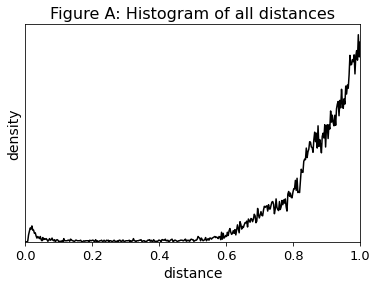

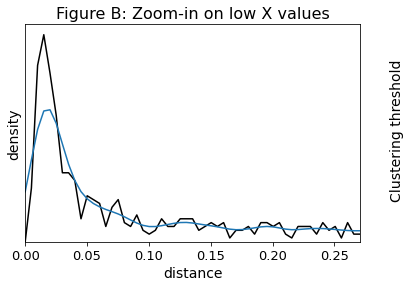

In [27]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def plot(xs, ys, title, xlabel, ylabel):
    figure = plt.figure()
    plt.plot(xs, ys, color='k')
    plt.tick_params(left=False, labelleft=False, labelsize=13)
    plt.ylim(0, plt.ylim()[1])
    plt.xlim(0, xs.max())
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    return figure

#histogram = vamb.vambtools.read_npz('histogram.npz')
xs = np.linspace(0, 1, 400)
fig_a = plot(xs[1:], histogram, "Figure A: Histogram of all distances", 'distance', 'density')
hist2 = histogram[0:120:2] + histogram[1:120:2]
fig_b = plot(xs[0:110:2], hist2[:55], "Figure B: Zoom-in on low X values", 'distance', 'density')
densities = calc_densities(hist2)
plt.plot(xs[0:110:2], densities[:55])
success,_,threshold = find_valley_ratio(densities, peak_valley_ratio=0.5)
plt.vlines(threshold, 0, plt.ylim()[1], linestyles='dotted')
plt.text(threshold, plt.ylim()[1]/5, "Clustering threshold", rotation=90, fontsize=14)

In [5]:
from DRBin.AAE_cluster import *
from Bio import SeqIO

import DRBin
import DRBin.utils
from DRBin import process

In [245]:
contig_length = {}
contig_id_idx = {}
contig_idx_id = {}
contigs = '/home/maog/data/airways/contigs.fna'
for record in SeqIO.parse(contigs, "fasta"):
    contig_length[record.id] = len(record.seq)
    contig_idx_id[len(contig_id_idx)] = record.id
    contig_id_idx[record.id] = len(contig_id_idx)

In [12]:
output = '/home/maog/data/metahit'
res = perform_binning(output, contigs)
len(res.keys())

281

In [13]:
import collections
cluster = dict()
cluster = collections.defaultdict(set)
for k, v in res.items():
    for i in v:
        cluster[contig_idx_id[k]].add(contig_idx_id[i])
len(cluster.keys())

281

In [14]:
with open('/home/maog/data/metahit/AAE_cluster.tsv', 'w') as file:
    DRBin.utils.write_clusters(file, cluster)

In [15]:
reference_path = '/home/maog/data/metahit/reference.tsv'
#!head $reference_path # show first 10 lines of reference file
with open(reference_path) as reference_file:
    reference = DRBin.benchmark.Reference.from_file(reference_file)

taxonomy_path = '/home/maog/data/metahit/taxonomy.tsv'
#!head $taxonomy_path # show first 10 lines of reference file
with open(taxonomy_path) as taxonomy_file:
    reference.load_tax_file(taxonomy_file)

In [89]:
with open('/home/maog/data/metahit/AAE_cluster.tsv') as clusters_file:
    DRBin_clusters = DRBin.utils.read_clusters(clusters_file)
    DRBin_bins = DRBin.benchmark.Binning(DRBin_clusters, reference, minsize=100000)

In [90]:
print('DRBin bins:')
for rank in DRBin_bins.summary():
    print('\t'.join(map(str, rank)))

DRBin bins:
114	107	102	96	86	66	22	7	0
109	104	99	93	85	65	21	7	0
54	53	51	50	49	43	17	6	0


In [91]:
with open('/home/maog/data/metahit/vamb_cluster.tsv') as clusters_file:
    vamb_clusters = DRBin.utils.read_clusters(clusters_file)
    vamb_bins = DRBin.benchmark.Binning(vamb_clusters, reference, minsize=100000)

In [92]:
print('DRBin bins:')
for rank in vamb_bins.summary():
    print('\t'.join(map(str, rank)))

DRBin bins:
108	107	105	102	91	66	21	6	0
104	104	102	99	90	65	20	6	0
53	53	52	51	49	43	17	5	0


In [82]:
from sklearn.cluster import DBSCAN
labels = DBSCAN(eps = 0.06, min_samples = 50, metric = 'cosine').fit_predict(latent)

In [83]:
import collections
#clusters = dict()
clusters = collections.defaultdict(set)
for i in range(len(labels)):
    clusters[labels[i]]
len(clusters.keys())

183

In [84]:
for i in range(len(labels)):
    clusters[labels[i]].add(contig_idx_id[i])

In [85]:
len(clusters.keys())

183

In [86]:
with open('/home/maog/data/metahit/hdbscan_cluster.tsv', 'w') as file:
    DRBin.utils.write_clusters(file, clusters)

In [87]:
with open('/home/maog/data/metahit/hdbscan_cluster.tsv') as clusters_file:
    DRBin_clusters = DRBin.utils.read_clusters(clusters_file)
    DRBin_bins = DRBin.benchmark.Binning(DRBin_clusters, reference, minsize=100000)

In [88]:
print('DRBin bins:')
for rank in DRBin_bins.summary():
    print('\t'.join(map(str, rank)))

DRBin bins:
126	121	105	94	71	33	10	3	0
121	117	103	93	71	33	10	3	0
51	50	49	45	39	24	7	2	0


In [93]:
from DRBin.eval import *
print(calcu_f1score(vamb_bins))
print(calcu_f1score(DRBin_bins))

0.7859252091215118
0.8613777268829388


In [28]:
ls

AAE.ipynb  example.ipynb  README.md          show_DRBin.ipynb  vMF-VAE.ipynb
DRBin/     __pycache__/   show_DGRBin.ipynb  test_data/


In [2]:
with open('/home/maog/data/best_practice/case1/case1_depth.txt') as file:
    depths = _vambtools.load_jgi(file)

In [12]:
ls /maog/data/best_practice

ls: cannot access '/maog/data/best_practice': No such file or directory


In [5]:
depths.shape

(79862, 42)

In [10]:
np.savez('/home/maog/data/best_practice/case1/case1_depth.npz', depths)

In [11]:
RPKMs = _vambtools.read_npz('/home/maog/data/best_practice/case1/case1_depth.npz')

In [13]:
RPKMs.shape

(79862, 42)